In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import collections
import itertools

import inept
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch


# Style
sns.set_theme(context='paper', style='white', palette='Set2')

In [3]:
# Original paper (pg 24)
# https://arxiv.org/pdf/1909.07528.pdf

# Original blog
# https://openai.com/research/emergent-tool-use

# Slides
# https://glouppe.github.io/info8004-advanced-machine-learning/pdf/pleroy-hide-and-seek.pdf

# PPO implementation
# https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py#L38

# Residual SA
# https://github.com/openai/multi-agent-emergence-environments/blob/bafaf1e11e6398624116761f91ae7c93b136f395/ma_policy/layers.py#L89


In [4]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Create Environment

In [5]:
# Params
num_nodes = 5
num_dims = 2

# Data
M1 = torch.rand((num_nodes, 2))
M2 = torch.rand((num_nodes, 3))
modalities = (M1,)

# Environment
# x, y, vx, vy
env = inept.environments.trajectory(*modalities, dim=num_dims, reward_type='euclidean')

### Train Policy

In [6]:
# Make policy
input_dims = 2*num_dims+sum([m.shape[1] for m in modalities])
policy = inept.models.PPO(input_dims, num_dims)

# Parameters
# NOTE: Can probably train faster, just decay more frequently and decrease max_timesteps
max_ep_timesteps = 1e2  # 1e3
max_timesteps = 1e6  # 1e6
update_timesteps = 40 * max_ep_timesteps  # 4 * max_ep_timesteps
decay_timesteps = 1e5  # 2.5e5

# Simulation loop
print('Beginning training')
timestep = 0; episode = 1; recording = collections.defaultdict(lambda: []); stats = collections.defaultdict(lambda: [])
while timestep < max_timesteps:
    # Reset environment
    env.reset()

    # Start episode
    ep_timestep = 0; ep_reward = 0
    while ep_timestep < max_ep_timesteps:
        # Get current state
        state = env.get_state(include_modalities=True)
        recording['states'].append(state)

        # Get self features for each node
        self_entity = state

        # Get node features for each state
        idx = torch.zeros((num_nodes, num_nodes), dtype=torch.bool)
        for i, j in itertools.product(*[range(x) for x in idx.shape]):
            idx[i, j] = i!=j
        node_entities = state.unsqueeze(0).expand(num_nodes, *state.shape)
        node_entities = node_entities[idx].reshape(num_nodes, num_nodes-1, input_dims)

        # Get actions from policy
        actions = policy.act(self_entity, node_entities)

        # Step environment and get reward
        rewards, finished = env.step(actions)

        # Record rewards
        for key in range(num_nodes):
            policy.memory.rewards.append(rewards[key].item())  # Could just add lists
            policy.memory.is_terminals.append(finished)
        ep_reward = ep_reward + rewards.sum()
        recording['rewards'].append(rewards.numpy())

        # Iterate
        timestep += 1
        ep_timestep += 1

        # Decay model std
        if timestep % decay_timesteps == 0:
            policy.decay_action_std()
            print(f'Decaying std to {policy.action_std} on episode {episode} and timestep {timestep}')

        # Update model
        if timestep % update_timesteps == 0:
            print(f'Updating model with average reward {np.mean(policy.memory.rewards)} on episode {episode} and timestep {timestep}')
            policy.update()

        # Escape if finished
        if finished: break

    # Record stats
    ep_reward = ep_reward / (num_nodes * ep_timestep)
    stats['episode'].append(episode)
    stats['end_timestep'].append(timestep)
    stats['average_reward'].append(ep_reward.item())
    stats['action_std'].append(policy.action_std)
    stats['update'].append(int(timestep / update_timesteps))

    # Iterate
    episode += 1

Beginning training
Updating model with average reward -1.0676157819130225 on episode 40 and timestep 4000
Updating model with average reward -0.9235918839474704 on episode 80 and timestep 8000
Updating model with average reward -0.8688174126887287 on episode 120 and timestep 12000
Updating model with average reward -0.7677544462357065 on episode 160 and timestep 16000
Updating model with average reward -0.6794605504959647 on episode 200 and timestep 20000
Updating model with average reward -0.62390426744672 on episode 240 and timestep 24000
Updating model with average reward -0.5670455683175707 on episode 280 and timestep 28000
Updating model with average reward -0.5169776737084845 on episode 320 and timestep 32000
Updating model with average reward -0.48258039308490697 on episode 360 and timestep 36000
Updating model with average reward -0.46072903880611993 on episode 400 and timestep 40000
Updating model with average reward -0.43994698483665706 on episode 440 and timestep 44000
Updat

In [7]:
# Format states and stats
states = np.stack(recording['states'], axis=0)
rewards = np.array([rwds.mean() for rwds in recording['rewards']])
stats = pd.DataFrame(stats)

### Plot Performance

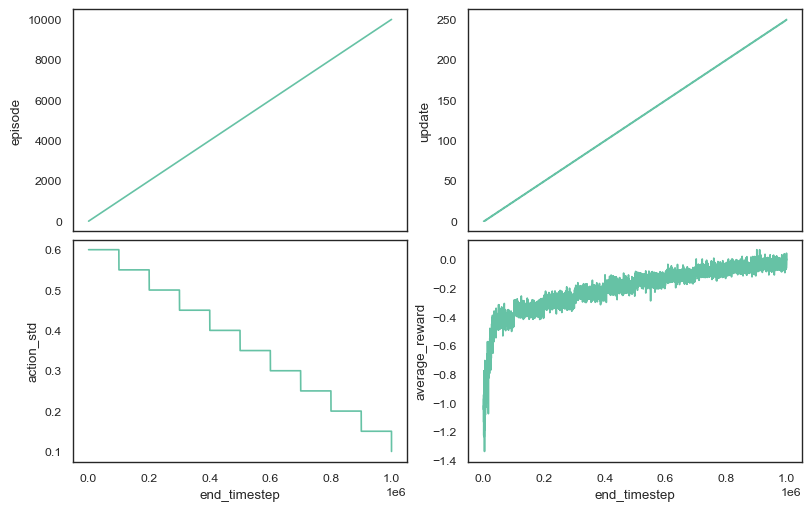

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, layout='constrained')
axs = axs.flatten()
sns.lineplot(stats, x='end_timestep', y='episode', ax=axs[0])
sns.lineplot(stats, x='end_timestep', y='update', ax=axs[1])
sns.lineplot(stats, x='end_timestep', y='action_std', ax=axs[2])
sns.lineplot(stats, x='end_timestep', y='average_reward', ax=axs[3])
plt.show()

### Animate Latent Space

In [14]:
# Parameters
fraction_to_show = 1  # Show 1/`fraction_to_show` of the full runtime
skip = 1  # Only show 1 in every `skip` frames

# Subset
first_frame = max_ep_timesteps
last_frame = max_ep_timesteps-max_ep_timesteps/fraction_to_show+1
if ep_timestep != max_ep_timesteps:  # Adjust in case interrupted
    first_frame += ep_timestep
    last_frame += ep_timestep
anim_states = states[-int(first_frame):-int(last_frame):skip]
anim_rewards = rewards[-int(first_frame):-int(last_frame):skip]

# Create figure
fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
plt.sca(ax)

# Initial scatter
sct = ax.scatter(*anim_states[0, :, :num_dims].T)

# Update function
def update(frame):
    # Filter data
    sct.set_offsets(anim_states[frame, :, :num_dims])

    # Get rewards
    reward_from_frame = anim_rewards[frame]

    # Format
    ax.set_title(reward_from_frame)
    ax.set_aspect('equal')
    ax.set_xlim([-env.pos_bound-.2, env.pos_bound+.2])
    ax.set_ylim([-env.pos_bound-.2, env.pos_bound+.2])

    return sct

# Run animation
timescale = 3
ani = animation.FuncAnimation(fig=fig, func=update, frames=anim_states.shape[0], interval=skip*(1/timescale)*1000*env.delta)

# Save animation
ani.save('sample.gif')
plt.close()

# Show animation
from IPython.display import HTML
HTML(ani.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


In [10]:
env.pos = M1
inept.utilities.euclidean_distance(env.pos)


tensor([[0.0000, 0.5014, 0.5836, 0.6374, 0.7840],
        [0.5014, 0.0000, 0.3585, 0.2083, 0.9969],
        [0.5836, 0.3585, 0.0000, 0.2347, 0.7222],
        [0.6374, 0.2083, 0.2347, 0.0000, 0.9510],
        [0.7840, 0.9969, 0.7222, 0.9510, 0.0000]])

In [11]:
env.pos = torch.tensor(anim_states[-1, :, :2])
inept.utilities.euclidean_distance(env.pos)


tensor([[0.0000, 0.3971, 0.7819, 0.4916, 1.0282],
        [0.3971, 0.0000, 0.4344, 0.1745, 0.8759],
        [0.7819, 0.4344, 0.0000, 0.5134, 0.6055],
        [0.4916, 0.1745, 0.5134, 0.0000, 1.0257],
        [1.0282, 0.8759, 0.6055, 1.0257, 0.0000]])

In [12]:
env.get_distance_match(measure=inept.utilities.euclidean_distance)

tensor([0.0262, 0.0065, 0.0273, 0.0211, 0.0187])

In [13]:
# TODO
# Be more selective with state recordings
# Link to weights and biases or similar
# Implement model saving
# Try training on few points and transferring to more
# Match architecture and vars to paper
# Try on real data, probably with new reward function based on metadata
# Write README